In [1]:
# %% Imports

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
# import pprint
import os
# import sklearn
from IPython.display import display as display
import sys
import missingno as msno

import seaborn as sns


In [2]:
# %% Preliminaries

sns.set_palette("PuBuGn_d")
sns.set_style('darkgrid')

%matplotlib inline

In [3]:
#%% Load data

df_kiva_loans = pd.read_csv("data/kiva_loans.csv")
df_loc = pd.read_csv("data/loan_themes_by_region.csv")
df_themes = pd.read_csv("data/loan_theme_ids.csv")
df_mpi = pd.read_csv("data/kiva_mpi_region_locations.csv")

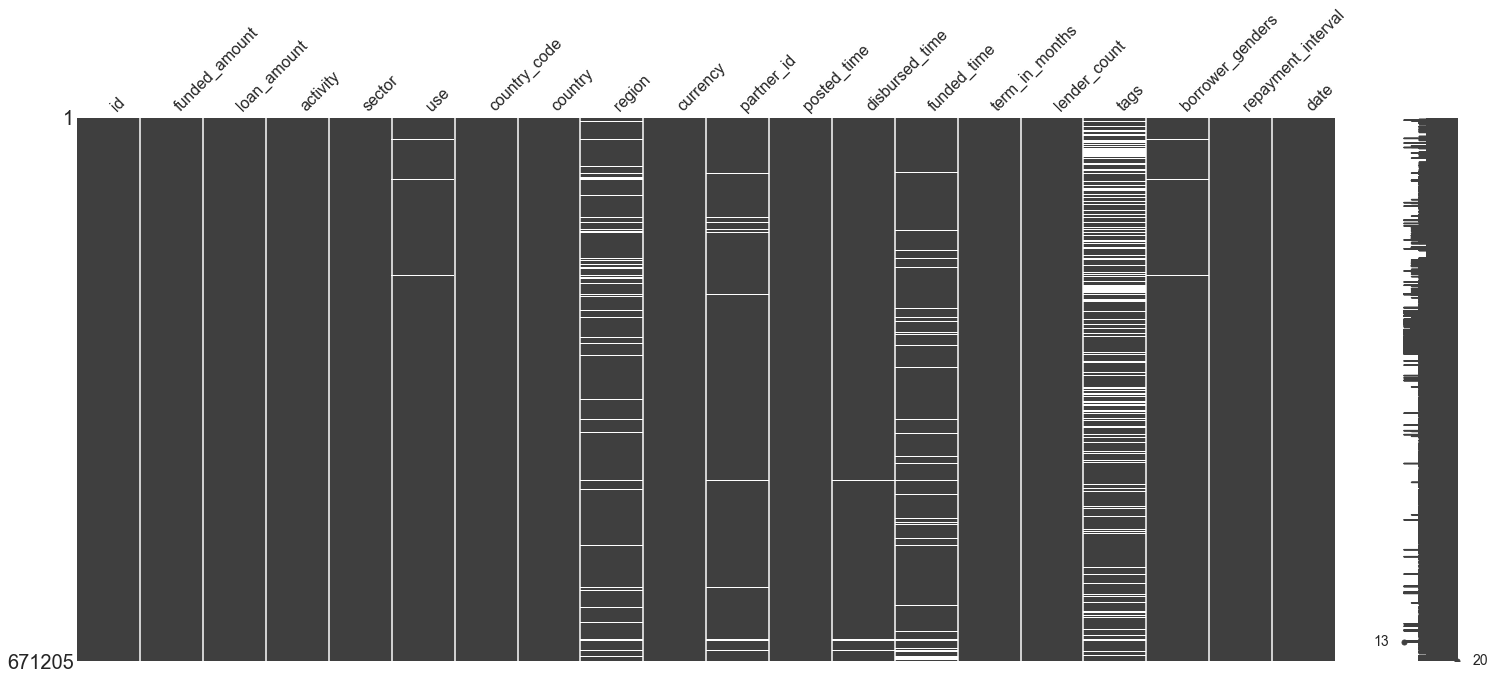

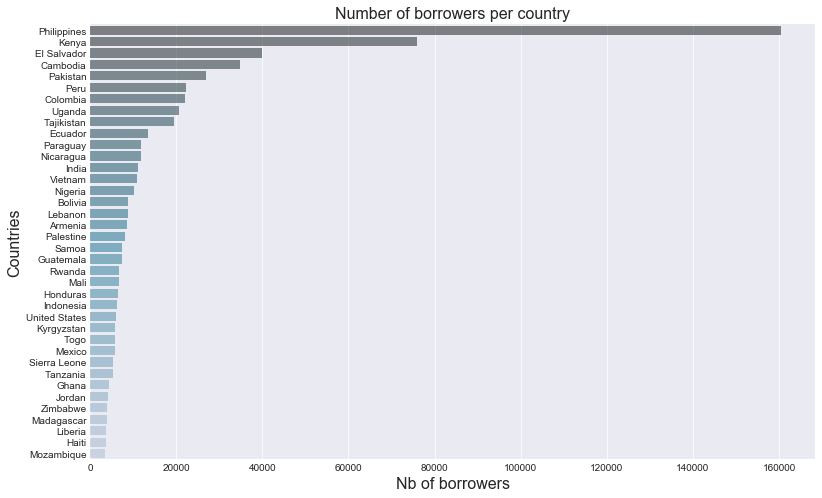

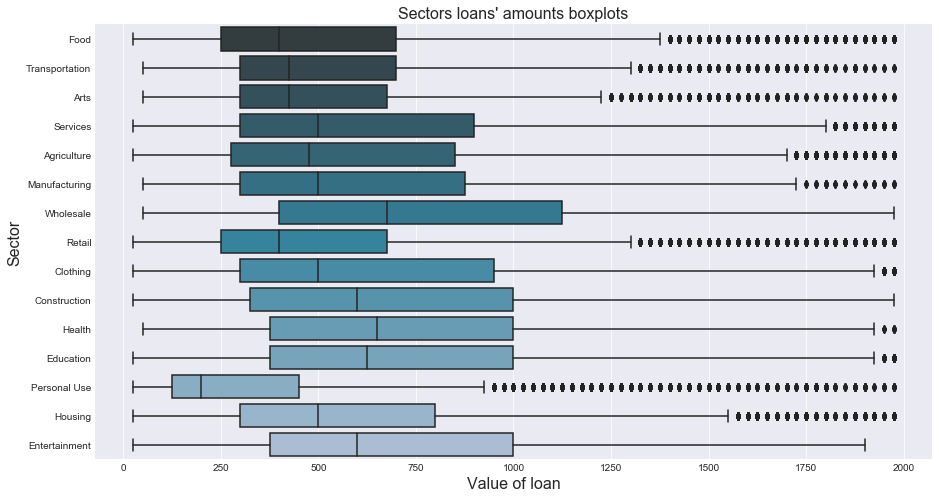

In [4]:
# %% Exploring the loans data with visualisations

## Missing data
msno.matrix(df_kiva_loans)
plt.show()

df_kiva_loans.describe(include = 'all')

## Country
countries = df_kiva_loans['country'].value_counts()[df_kiva_loans['country'].value_counts()>3400]
list_countries = list(countries.index)

plt.figure(figsize=(13,8))
sns.barplot(y=countries.index, x=countries.values, alpha=0.6,palette="PuBuGn_d")
plt.title("Number of borrowers per country", fontsize=16)
plt.xlabel("Nb of borrowers", fontsize=16)
plt.ylabel("Countries", fontsize=16)
plt.show();

## Loan amounts
temp = df_kiva_loans[df_kiva_loans['loan_amount']<2000]
plt.figure(figsize=(15,8))
sns.boxplot(x='loan_amount', y="sector", data=temp,palette="PuBuGn_d")
plt.xlabel("Value of loan", fontsize=16)
plt.ylabel("Sector", fontsize=16)
plt.title("Sectors loans' amounts boxplots", fontsize=16)
plt.show();



In [5]:
df_kiva_loans.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


In [6]:
#%% Cleaning DHS data

clusters = pd.read_csv('data/kivadhsv1/DHS.clusters.csv')

clusters= clusters.drop_duplicates()[['DHSCLUST','DHSCC.x', 'DHS.lat',
                    'DHS.lon','Country','MPI.median', 'Nb.HH', 'AssetInd.median',
                    'URBAN_RURA','Nb.Electricity', 'Nb.fuel', 'Nb.floor',
                    'Nb.imp.sanitation', 'Nb.imp.water', 'Median.educ',
                    'Nb.television', 'Nb.phone']]
clusters.describe()
##Drop empty observation
clusters.drop(clusters.index[4987],inplace=True)
clusters[['DHS.lat', 'DHS.lon']] = clusters[['DHS.lat', 'DHS.lon']].astype(float,inplace=True)

# Convert to int and divide by number of households to get a ratio
for i in ['Nb.Electricity','Nb.fuel','Nb.floor','Nb.imp.sanitation','Nb.imp.water','Nb.television','Nb.phone','Nb.television'] :
    clusters[i]=round(100*clusters[i].astype(int)/clusters['Nb.HH'].astype(int),2)

# Indicator variable for urban/rural
clusters['URBAN_RURA']=clusters['URBAN_RURA'].apply (lambda x : 1 if x=='U' else 0 )

# Add country marker to dhscluster var
clusters['DHSCLUST']=[str(clusters['DHSCLUST'].iloc[i])+'_'+clusters['Country'].iloc[i] for i in range(len(clusters)) ]

# Convert type
clusters['AssetInd.median']=clusters['AssetInd.median'].astype(float)
# Rescale median between 0 and 100
max_asset = max(clusters['AssetInd.median'])
min_asset = min(clusters['AssetInd.median'])
clusters['AssetInd.median']=clusters['AssetInd.median'].apply(lambda x : round((100/(max_asset-min_asset)) * (x-min_asset),2))

# Renaming columns
clusters.rename(columns={"MPI.median":"MPI_cluster", "AssetInd.median" : "wealth_index",
                        "URBAN_RURA": "urban" , 'Nb.Electricity':'ratio_electricity',
                        'Nb.imp.sanitation':'ratio_sanitation','Nb.imp.water':'ratio_water', 'Nb.phone':'ratio_phone',
                        'Nb.floor':'ratio_nakedSoil','Nb.fuel':'ratio_cookingFuel',
                        'Nb.television':'ratio_television'}, inplace=True)

#Convert to float
clusters['MPI_cluster']=clusters['MPI_cluster'].astype(float,inplace=True)

#Scaling
from sklearn.preprocessing import StandardScaler
clusters[['urban' ,'ratio_sanitation','ratio_phone', 'ratio_electricity',
        'ratio_cookingFuel', 'ratio_nakedSoil','ratio_water']] = StandardScaler().fit_transform(clusters[['urban' ,'ratio_sanitation','ratio_phone',
                                                'ratio_electricity', 'ratio_cookingFuel',
                                                 'ratio_nakedSoil','ratio_water']])

clusters.head()

,DHSCLUST,DHSCC.x,DHS.lat,DHS.lon,Country,MPI_cluster,Nb.HH,wealth_index,urban,ratio_electricity,ratio_cookingFuel,ratio_nakedSoil,ratio_sanitation,ratio_water,Median.educ,ratio_television,ratio_phone
0,1_COL,CO,11.544571,-72.921327,COL,0.0,7,73.67,0.731433,-0.455233,-0.712197,-0.493856,-0.841506,-0.356097,0,1428.57,0.864721
1,2_COL,CO,11.545763,-72.913614,COL,0.0,4,72.66,0.731433,-0.455233,-0.712197,-0.493856,-0.841506,-0.356097,0,2500.00,1.393553
2,3_COL,CO,11.549456,-72.908101,COL,0.0,8,62.57,0.731433,-0.455233,-0.712197,-0.493856,-0.010832,-0.356097,0,1250.00,0.283185
3,4_COL,CO,11.550513,-72.901499,COL,0.0,9,65.13,0.731433,-0.455233,-0.418447,-0.493856,-0.472355,0.165767,0,1111.11,0.159712
4,5_COL,CO,11.542879,-72.919899,COL,0.0,8,66.28,0.731433,-0.455233,-0.712197,-0.493856,-0.841506,-0.356097,0,1250.00,0.283185


In [7]:
clusters[['MPI_cluster']].describe()

,MPI_cluster
count,6777.000000
mean,10.031605
std,13.508466
min,0.000000
25%,0.000000
50%,5.560000
75%,16.680000
max,61.140000


In [8]:
#%% Benchmark model

from statsmodels.formula.api import ols
clusters_clmb = clusters[clusters['Country']=='COL']

model_clmb= ols(formula = 'MPI_cluster ~ urban + ratio_sanitation +ratio_phone+\
 ratio_electricity+ ratio_cookingFuel+ratio_nakedSoil+ratio_water+ratio_television',
          data = clusters_clmb).fit()

print(model_clmb.summary())


                            OLS Regression Results                            
Dep. Variable:            MPI_cluster   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     2440.
Date:                Thu, 31 May 2018   Prob (F-statistic):               0.00
Time:                        16:41:17   Log-Likelihood:                -16778.
No. Observations:                5295   AIC:                         3.357e+04
Df Residuals:                    5286   BIC:                         3.363e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            12.0777      0.14

In [9]:
loan_coords = pd.read_csv('data/additional/loan_coords.csv')
loans_extended = pd.read_csv('data/additional/loans.csv')
loans_with_coords = loans_extended.merge(loan_coords, how='left', on='loan_id')

loans_with_coords=loans_with_coords[['loan_id','country_code','country_name','town_name','latitude','longitude',
                                    'original_language','description','description_translated','tags', 'activity_name','sector_name','loan_use',
                                    'loan_amount','funded_amount',
                                    'posted_time','planned_expiration_time','disburse_time', 'raised_time', 'lender_term', 'num_lenders_total','repayment_interval']]
loans_with_coords = loans_with_coords[np.isfinite(loans_with_coords['latitude'])]

loans = loans_with_coords[loans_with_coords['country_name'].isin(['Philippines','Colombia','Armenia','Kenya','Haiti'])]

loans.sample(10)


,loan_id,country_code,country_name,town_name,latitude,longitude,original_language,description,description_translated,tags,...,loan_use,loan_amount,funded_amount,posted_time,planned_expiration_time,disburse_time,raised_time,lender_term,num_lenders_total,repayment_interval
156845,1143468,KE,Kenya,Thika,-1.038757,37.083375,English,The lady raising her hand in the photo is Este...,The lady raising her hand in the photo is Este...,"#Parent, #Schooling",...,To buy fertilizer for increased production.,600.0,600.0,2016-09-01 04:40:49.000 +0000,2016-10-10 16:30:07.000 +0000,2016-08-01 07:00:00.000 +0000,2016-09-26 04:38:52.000 +0000,14.0,20,monthly
686054,979191,KE,Kenya,Mariakani,-3.863457,39.473761,English,Derrick is 38 years old and a farmer at Mariak...,Derrick is 38 years old and a farmer at Mariak...,"#Repeat Borrower, #Vegan",...,to purchase fertilizer and maize seeds.,200.0,200.0,2015-11-16 08:27:41.000 +0000,2015-12-19 13:50:03.000 +0000,2015-10-26 07:00:00.000 +0000,2015-11-26 14:34:23.000 +0000,14.0,8,monthly
871245,942730,PH,Philippines,"Pilar, Bohol",9.841146,124.353242,English,Hilda is a merchant living in the town of Pila...,Hilda is a merchant living in the town of Pila...,"#Woman Owned Biz, #Parent",...,to buy supplies for her store,650.0,650.0,2015-09-03 07:08:58.000 +0000,2015-10-05 13:00:03.000 +0000,2015-08-19 07:00:00.000 +0000,2015-10-05 12:56:55.000 +0000,8.0,22,irregular
122960,1188925,PH,Philippines,Hilongos Leyte,10.370812,124.753367,English,Nena is a 54-year-old married woman. She is in...,Nena is a 54-year-old married woman. She is in...,"#Woman Owned Biz, #Repeat Borrower, #Elderly",...,to buy fertilizer and other farm supplies.,625.0,625.0,2016-11-21 07:50:21.000 +0000,2016-12-25 06:00:04.000 +0000,2016-10-25 07:00:00.000 +0000,2016-11-25 10:53:54.000 +0000,8.0,2,irregular
1091319,516318,KE,Kenya,Kasarani,-1.228014,36.894974,English,"Simon is 35 years old, married to Ruth, and bl...",NaN,NaN,...,"To expand his business, by purchasing new mach...",925.0,925.0,2013-01-11 06:45:46.000 +0000,2013-02-10 18:20:02.000 +0000,2012-12-17 08:00:00.000 +0000,2013-01-12 17:36:03.000 +0000,14.0,33,monthly
166848,190200,PH,Philippines,"Sagay, Camiguin",9.124948,124.740929,English,"Russel G., from the village of Balite, Sagay, ...",NaN,NaN,...,To purchase new items to expand product offering,100.0,100.0,2010-03-30 02:46:51.000 +0000,NaN,2010-03-01 08:00:00.000 +0000,2010-03-30 15:43:36.000 +0000,6.0,3,irregular
1128940,886034,KE,Kenya,Voi,-3.397310,38.555934,English,"Marieta is married, and has two kids who atten...","Marieta is married, and has two kids who atten...","user_favorite, #Animals, #Parent",...,to purchase more chicken for her business.,525.0,525.0,2015-05-15 08:49:02.000 +0000,2015-06-16 05:00:03.000 +0000,2015-05-14 07:00:00.000 +0000,2015-06-15 22:11:13.000 +0000,13.0,16,irregular
841985,860644,KE,Kenya,Nyandarua South,-0.399410,36.489516,English,Mary is 60 years old. She is a widow blessed w...,Mary is 60 years old. She is a widow blessed w...,NaN,...,"to purchase fertilizer and pesticides, add see...",225.0,225.0,2015-03-24 09:15:04.000 +0000,2015-04-28 23:00:08.000 +0000,2015-03-09 07:00:00.000 +0000,2015-03-30 07:32:41.000 +0000,8.0,7,monthly
68455,661770,PH,Philippines,"Himamaylan, Negros Occidental",10.090218,122.868368,English,Josefina is 40 years old and married with two ...,NaN,NaN,...,to purchase additional items to sell like can ...,200.0,200.0,2014-01-25 12:16:06.000 +0000,2014-03-27 00:10:34.000 +0000,2014-01-17 08:00:00.000 +0000,2014-02-25 22:34:10.000 +0000,11.0,7,irregular
890984,1353738,PH,Philippines,"Calbayog City, Samar",12.067575,124.592957,English,"Rosana is 58 years old and married, with 9 chi...","Rosana is 58 years old and married, with 9 chi...",NaN,...,"to buy items to sell like beverages, canned go...",250.0,250.0,2017-08-07 22:56:16.000 +0000,2017-09-20 14:20:05.000 +0000,2017-07-14 07:00:00.000 +0000,2017-08-21 14:25:18.000 +0000,8.0,1,irregular


In [10]:
#%% Running KNN to assign DHS clusters to loans
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1 , metric='haversine')
neigh.fit(np.radians(clusters[['DHS.lat', 'DHS.lon']]), clusters['DHSCLUST'])
loans['DHSCLUST'] = neigh.predict(np.radians(loans[['latitude','longitude']]))

'''Build a table to show the coordinates of the loan and coordinates of the cluster it is assigned to, then calculate the Haversine distance in kilometers between cluster and loan'''

merged_df = loans.merge(clusters, how='left', on='DHSCLUST')
lat1 = np.radians(merged_df['latitude'])
lat2 = np.radians(merged_df['DHS.lat'])
lon1 = np.radians(merged_df['longitude'])
lon2 = np.radians(merged_df['DHS.lon'])
temp = np.power((np.sin((lat2-lat1)/2)),2) + np.cos(lat1) * np.cos(lat2) * np.power((np.sin((lon2-lon1)/2)),2)
merged_df['distance_km'] = 6371 * (2 * np.arcsin(np.sqrt(temp))) #6371 is the radius of the earth



merged_df.sample(50)


C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,loan_id,country_code,country_name,town_name,latitude,longitude,original_language,description,description_translated,tags,...,urban,ratio_electricity,ratio_cookingFuel,ratio_nakedSoil,ratio_sanitation,ratio_water,Median.educ,ratio_television,ratio_phone,distance_km
38626,979023,PH,Philippines,"Guihulngan, Negros Oriental",10.183230,123.213851,English,Clara is 53 years old and has 13 children. She...,Clara is 53 years old and has 13 children. She...,"#Animals, #Elderly, #Parent, #Repeat Borrower,...",...,-1.367179,2.857796,1.931823,0.014122,2.481192,-0.356097,0,61.11,-0.827184,17.619269
53067,760036,PH,Philippines,"Maasin City, Leyte",10.165355,124.840341,English,Erma is 60 years old and married with seven ch...,Erma is 60 years old and married with seven ch...,NaN,...,-1.367179,-0.121264,1.680112,-0.058577,1.531897,-0.356097,0,338.10,-0.827184,18.455767
105692,505860,PH,Philippines,"Bago, Negros Occidental",10.503405,122.966302,English,"Erlinda is 61 years old, married and the mothe...",NaN,NaN,...,-1.367179,-0.248958,1.931823,0.313147,1.503987,-0.356097,0,411.76,-0.827184,7.760766
267696,833941,PH,Philippines,"Escalante, Negros Occidental",10.829146,123.505602,English,Purita is 58 years old. She is a widow woman w...,Purita is 58 years old. She is a widow woman w...,user_favorite,...,-1.367179,1.298806,1.931823,0.159520,2.481192,-0.356097,0,357.14,-0.827184,8.933359
361505,941032,AM,Armenia,Artik town,40.619903,43.970816,English,Artur provides auto repair service in Artik to...,Artur provides auto repair service in Artik to...,#Parent,...,-1.367179,-0.455233,-0.051192,-0.112987,0.543062,-0.356097,0,758.33,-0.827184,11493.631161
25446,1099864,PH,Philippines,"Guiuan, Eastern Samar",11.035248,125.724502,English,Veronica works hard to support six children. S...,Veronica works hard to support six children. S...,user_favorite,...,-1.367179,-0.085833,1.235917,-0.493856,1.082004,-0.356097,0,300.00,-0.671436,17.204944
204753,899975,PH,Philippines,"Brookes Point, Palawan",8.818934,117.784246,English,Precy is married with four children. She is a ...,Precy is married with four children. She is a ...,"#Parent, #Woman Owned Biz",...,-1.367179,2.663098,1.833994,-0.324682,2.358252,0.513834,1,11.11,-0.827184,6.510215
324363,1171651,HT,Haiti,Artibonite,19.362902,-72.425815,English,Nestor is a community leader in Artibonite. La...,Nestor is a community leader in Artibonite. La...,"user_favorite, user_favorite",...,-1.367179,3.052845,1.931823,3.762914,0.418793,-0.031987,1,0.00,-0.827184,3.611108
224294,1097384,KE,Kenya,Msambweni,-4.465290,39.481266,English,Mwanasiti is the married mother of three child...,Mwanasiti is the married mother of three child...,"#Parent, #Woman Owned Biz, #Schooling, #Vegan,...",...,0.731433,1.120946,-0.712197,0.036069,1.807017,-0.015546,0,0.00,-0.827184,20.581885
326294,561209,PH,Philippines,"Tanjay, Negros Oriental",9.495788,122.966302,English,"Mercy is 43 years old, married, and has four c...",NaN,user_favorite,...,-1.367179,0.563162,1.420205,-0.346172,1.730927,-0.356097,0,164.52,-0.540561,11.857443


In [11]:
#%% Feature selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
mergedCOL = merged_df[merged_df['country_name']=='Colombia']

model = LinearRegression()
selector = RFE(model,5,step=1)
selector=selector.fit(mergedCOL[['latitude','longitude','urban','ratio_sanitation',
'ratio_electricity','ratio_water','ratio_phone','ratio_nakedSoil','ratio_cookingFuel',
'ratio_television']],mergedCOL['MPI_cluster'])
selector.support_
selector.ranking_

array([5, 3, 4, 1, 1, 1, 2, 1, 1, 6])

In [12]:
#%% Final chosen model
model = ols(formula = 'MPI_cluster ~ ratio_sanitation+\
ratio_electricity+ ratio_cookingFuel+ratio_nakedSoil+ratio_water+urban+ratio_phone+latitude+longitude',
          data = mergedCOL).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            MPI_cluster   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                 1.743e+04
Date:                Thu, 31 May 2018   Prob (F-statistic):               0.00
Time:                        16:42:50   Log-Likelihood:                -91913.
No. Observations:               31187   AIC:                         1.838e+05
Df Residuals:                   31177   BIC:                         1.839e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           111.9895      3.51

C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:          funded_amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8286
Date:                Thu, 31 May 2018   Prob (F-statistic):              0.363
Time:                        16:42:51   Log-Likelihood:            -2.4032e+05
No. Observations:               31187   AIC:                         4.806e+05
Df Residuals:                   31185   BIC:                         4.807e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     625.8013      3.422    182.879      

Text(0.5,1,'Regressing MPI by cluster on Funded amount')

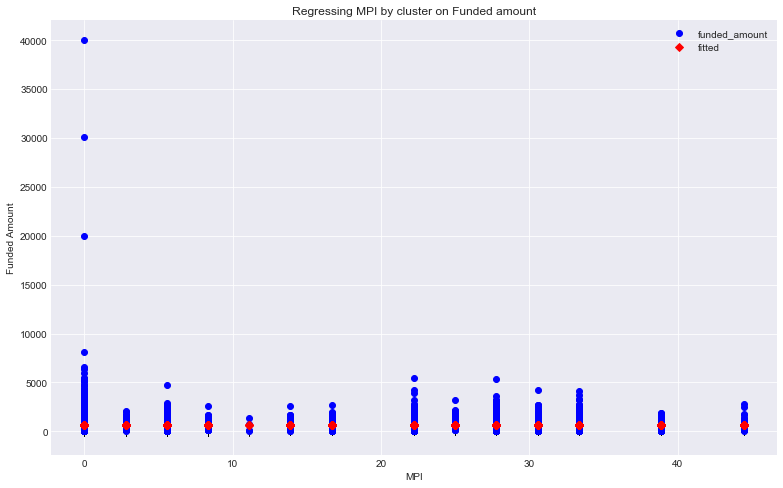

In [13]:
#%% Run an OLS algorithm on funded_amount and MPI
import statsmodels.api as sm
model = ols(formula = 'funded_amount ~ MPI_cluster',
          data = mergedCOL).fit()
print(model.summary())

fig, ax = plt.subplots(figsize=(13,8))
fig = sm.graphics.plot_fit(model, 1, ax=ax)
ax.set_ylabel("Funded Amount")
ax.set_xlabel("MPI")
ax.set_title("Regressing MPI by cluster on Funded amount")


In [21]:
## Cross Validation

from sklearn import cross_validation
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = cross_validation.train_test_split(mergedCOL[['latitude','longitude','urban','ratio_sanitation',
'ratio_electricity','ratio_water','ratio_phone','ratio_nakedSoil','ratio_cookingFuel',
'ratio_television']],mergedCOL['MPI_cluster'],test_size=0.2)

clf=LinearRegression()
clf.fit(X_train,y_train)
accuracy=clf.score(X_test,y_test)
print(accuracy)



0.8386870584162502
Scores: [-21.2271673  -22.83588026 -21.80792428 -20.42554664 -21.1622424
 -22.03652859 -21.59431363 -20.9418777  -20.48424492 -22.21147323]
Mean: -21.47271989644279
Standard deviation: 0.7321974007713364


In [24]:
## Implement K-fold Cross Validation

scores=cross_val_score(clf,mergedCOL[['latitude','longitude','urban','ratio_sanitation',
'ratio_electricity','ratio_water','ratio_phone','ratio_nakedSoil','ratio_cookingFuel',
'ratio_television']],mergedCOL['MPI_cluster'],cv=10)
#rmse_scores=np.sqrt(-scores)
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard deviation:", scores.std())

Scores: [0.84115253 0.84588108 0.83222067 0.83502708 0.82107196 0.83091923
 0.83281249 0.84021726 0.82968645 0.8346171 ]
Mean: 0.8343605849112394
Standard deviation: 0.006564425512656119
